Import all necessary modules

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, FunctionTransformer, RobustScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error

from tanzania import extend_train_test_with_countries, save_png, Colors

Colors.init_colors()

Define new transformer, which can add a new feature as a sum of others

In [14]:
class AddSumFeature(BaseEstimator, TransformerMixin):
    def __init__(self, col_src: tuple, col_tgt: str):
        self.col_src = col_src
        self.col_tgt = col_tgt

    def fit(self, X, y = None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = pd.DataFrame(X).copy()
        X[self.col_tgt] = X[self.col_src].sum(axis = 1)
        return X

    def set_output(self, transform: str = None):
        return self

Get data with country data columns attached. Drop 'ID' column, as it is not imortant for model training. extract y to mak etrain-test split possible

In [15]:
X = extend_train_test_with_countries(pd.read_csv('data/Train.csv'))
X.drop('ID', axis = 1, inplace = True)

y = X.pop('total_cost')

In [16]:
X

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,...,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,continent,median_salary,distance
0,SWITZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,...,No,No,13.0,0.0,Cash,No,Friendly People,Europe,9836.07,6511.966
1,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,...,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",Europe,6300.00,7247.688
2,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,...,No,No,1.0,31.0,Cash,No,Excellent Experience,Europe,6300.00,7247.688
3,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,...,Yes,No,11.0,0.0,Cash,Yes,Friendly People,Europe,6300.00,7247.688
4,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,...,No,No,7.0,4.0,Cash,Yes,No comments,Asia,3684.93,9656.774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4804,UNITED ARAB EMIRATES,45-64,Alone,0.0,1.0,Business,Hunting tourism,"Friends, relatives",Independent,No,...,No,No,2.0,0.0,Credit Card,No,No comments,Asia,3324.25,3945.626
4805,UNITED STATES OF AMERICA,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,...,Yes,Yes,11.0,0.0,Cash,Yes,Friendly People,Northern America,6966.00,12407.919
4806,NETHERLANDS,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,others,Independent,No,...,No,No,3.0,7.0,Cash,Yes,Good service,Europe,4756.87,7115.211
4807,SOUTH AFRICA,25-44,Friends/Relatives,1.0,1.0,Business,Beach tourism,"Travel, agent, tour operator",Independent,Yes,...,No,No,5.0,0.0,Credit Card,No,Friendly People,Africa,1441.44,3554.013


split train-test. merge train X and y together to make them sync, when some rows will be dropped. there are very small amount of missed travel_with values, which can't be predicted by total_male + total_female = 1, drop those rows, same as rows, where total_male or total_female = np.nan. they are less than 1%

everything I should change in test data should be done using pipelines.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size= 0.75)

X_train = X_train.join(y_train)
# drop all the rows from dataset, wehere 'travel_with' = np.nan and total_male + total_female != 1. 20 items
mask = X_train['travel_with'].isna() & ((X_train['total_male'] + X_train['total_female']) != 1)
print(f'from {X_train.shape[0]} will remove {mask.sum()} because "travel_with" is unknown and number of tourists not 1')

X_train = X_train.drop(X_train[mask].index)

print(f'{X_train.shape[0]} rows left')

# drop all the rows, where total_male or total_female = np.nan
X_train = X_train.dropna(subset=['total_male', 'total_female'])
print(f'after not defined total_male and total_female {X_train.shape[0]} rows left')

y_train = X_train.pop('total_cost')


from 3606 will remove 20 because "travel_with" is unknown and number of tourists not 1
3586 rows left
after not defined total_male and total_female 3581 rows left


In [18]:
num_cols = [ col for col in X_train.columns if (X_train[col].dtype == 'int') or (X_train[col].dtype == 'float') ]
cat_cols = [ col for col in X_train.columns if X_train[col].dtype == 'object' ]
print(f'Numerical: {len(num_cols)}, Categorical: {len(cat_cols)}, Initially: {len(X_train.columns)}')

Numerical: 6, Categorical: 18, Initially: 24


As I already removed all the rows, where 'travel_width' is missed and can't be assigned as alone, I can use any of the following methods:

* Use SimpleImputer for one column Зшзу

In [ ]:

pipeline_most_impressing = Pipeline([
    ('value_impress', SimpleImputer(strategy='constant', fill_value = 'No comments')),
    ('onehot_impress', OneHotEncoder(handle_unknown='ignore'))
])

pipeline_travel_with = Pipeline([
    ('value_travel', SimpleImputer(strategy='constant', fill_value = 'Alone')),
    ('onehot_travel', OneHotEncoder(handle_unknown='ignore'))
])

pipeline_cat_other = Pipeline([
    ('imput_cats', SimpleImputer(strategy='most_frequent')),
    ('onehot_other', OneHotEncoder(handle_unknown='ignore'))
])

pipeline_numeric = Pipeline([
    ('imput_num', SimpleImputer(strategy='most_frequent').set_output(transform="pandas")),
    ('add_nights', Pipeline([
        ('nights', AddSumFeature(['night_mainland', 'night_zanzibar'], 'nights'))
        ])
    ),
    ('add_people', Pipeline([
        ('people', AddSumFeature(['total_male', 'total_female'], 'people'))
        ])
    ),
    ('scale_num', StandardScaler())
])

process_columns = ColumnTransformer([
    ('impressing', pipeline_most_impressing, ['most_impressing']),
    ('with', pipeline_travel_with, ['travel_with']),
    ('cats', pipeline_cat_other, [col for col in cat_cols if col not in ['most_impressing', 'travel_with']]),
    ('nums', pipeline_numeric, num_cols)
])


In [20]:
def create_model_report(name: str, y_test: pd.DataFrame, y_pred: pd.DataFrame):
    print(f'{name} model:')
    r2_test = r2_score(y_test, y_pred)
    rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
    print(f'RMSE = {rmse_test.round(3)}, R2_score = {r2_test.round(5)}')

    # make a graph
    residuals = y_test - y_pred

    plt.figure(figsize = (10, 6))
    df_test = pd.DataFrame({
        'real': y_test,
        'predicted': y_pred,
        'residuals': residuals
    })

    sns.scatterplot(data = df_test, y = 'residuals', x = 'predicted', color = Colors.dark_matcha_green)
    plt.axhline(0, color = Colors.accent_4, linestyle='--', linewidth = 3)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.title('Pipeline residuals plot')

    save_png(f'pics/{name}_model_performance.png')
    plt.show()


Linear Regression model:
RMSE = 9289033.417, R2_score = 0.4038


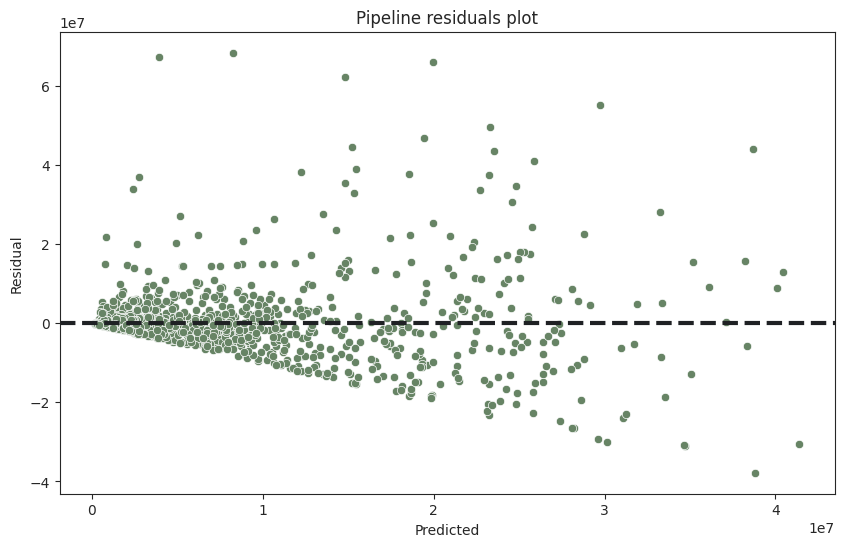

In [21]:
knn_pipe = Pipeline([
    ('prep', process_columns),
    ('model', KNeighborsRegressor(n_neighbors = 15, p=1, metric = 'minkowski', weights = 'uniform'))
])

knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)

create_model_report('Linear Regression', y_test, y_pred)

In [22]:
# estimators = [
#     ('Linear Regressor', LinearRegression(), {}),
#     ('Elastic Net', ElasticNet(), {
#         'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10],
#         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]
#         }),
#     ('KNeighborsRegressor', KNeighborsRegressor(n_jobs = -1), {
#         'n_neighbors': [3, 5, 7, 10],
#         'weights': ['uniform', 'distance'],
#         'p': [1, 2, 3]
#     }),
#     ('Decision Tree Regressor', DecisionTreeRegressor(max_features = 'sqrt'), {
#         'max_depth': [2, 5, 10, 15, 20],
#         'min_samples_split': range(2, 5),
#         'min_samples_leaf': [1, 2]}),
#     ('Random Forest Regressor', RandomForestRegressor(n_jobs = -1), {
#         'max_depth': [2, 5, 10, 15, 20],
#         'max_features': [None, 'sqrt', 'log2'],
#         'n_estimators': [50, 70, 90, 110, 150, 200],
#         'bootstrap': [True, False]}),
#     ('Ada Boost Regressor', AdaBoostRegressor(), {
#         'n_estimators': [50, 70, 90, 110, 150, 200],
#         'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
#         'loss': ['linear', 'square', 'exponential']}),
#     ('Gradient Boosting Regressor', GradientBoostingRegressor(), {
#         'n_estimators': [50, 70, 90, 110, 150, 200],
#         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#         'max_depth': [2, 3, 4, 5],
#         'max_features': [None, 'sqrt', 'log2']}),
#     ('SGD Regressor', SGDRegressor(max_iter = 5000), {
#         'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
#         'penalty': ['l2', 'l1', 'elasticnet'],
#         'l1_ratio': [0.1, 0.5, 0.9],
#     })
# ]
estimators = [
    # ('Linear Regressor', LinearRegression(), {}),
    # ('Elastic Net', ElasticNet(), {
    #     'alpha': [0.01, 0.1, 1, 10],
    #     'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1]
    #     }),
    # ('KNeighborsRegressor', KNeighborsRegressor(n_jobs = -1), {
    #     'n_neighbors': [3, 5, 7, 10],
    #     'weights': ['uniform', 'distance'],
    #     'p': [1, 2, 3]
    # }),
    # ('Decision Tree Regressor', DecisionTreeRegressor(max_features = 'sqrt'), {
    #     'max_depth': [2, 5, 10, 15, 20],
    #     'min_samples_split': range(2, 5),
    #     'min_samples_leaf': [1, 2]}),
    ('Random Forest Regressor', RandomForestRegressor(n_jobs = -1, bootstrap = True, max_features = 'sqrt'), {
        'max_depth': range(10, 20, 2),
        'n_estimators': range(10, 100, 10)}),
    # ('Ada Boost Regressor', AdaBoostRegressor(), {
    #     'n_estimators': [50, 70, 90, 110, 150, 200],
    #     'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    #     'loss': ['linear', 'square', 'exponential']}),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(), {
        'n_estimators': [90, 100, 110, 120, 150, 200],
        'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
        'max_depth': range(4, 7),
        'max_features': ['sqrt', 'log2']}),
    # ('SGD Regressor', SGDRegressor(max_iter = 5000), {
    #     'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
    #     'penalty': ['l2', 'l1', 'elasticnet'],
    #     'l1_ratio': [0.1, 0.5, 0.9],
    # })
]


In [23]:
results = []
for name, est, params in estimators:
    y_pred_check = y_test
    
    if len(params) == 0:
        ppline = Pipeline([
            ('prep', process_columns),
            ('model', est)
        ])
        ppline.fit(X_train, y_train)
        y_pred_check = ppline.predict(X_test)

        results.append([
            name, 
            r2_score(y_test, y_pred_check).round(4),
            (mean_squared_error(y_test, y_pred_check) ** 0.5).round(2),
            {},
            ppline])
    else:
        ppline = Pipeline([
            ('prep', process_columns),
            ('model', est)
        ])

        p_grid = {}
        for key, val in params.items():
            p_grid[f'model__{key}'] = val

        gs = GridSearchCV(
            estimator = ppline,
            param_grid = p_grid,
            n_jobs = -1,
            cv = 5,
            scoring = 'r2' #‘neg_root_mean_squared_error’
        )

        gs.fit(X_train, y_train)
        
        y_pred_check = gs.best_estimator_.predict(X_test)
        results.append([
            name, 
            r2_score(y_test, y_pred_check).round(4),
            (mean_squared_error(y_test, y_pred_check) ** 0.5).round(2),
            gs.best_params_,
            gs.best_estimator_])
    
    print(f'{name:35} R2: {r2_score(y_test, y_pred_check).round(4)}')

print('===' * 30)
for r in results:
    print(f'{r[0]:35} R2: {r[1]}, RMSE: {r[2]}, best params: {r[3]}')




Random Forest Regressor             R2: 0.4298
Gradient Boosting Regressor         R2: 0.4328
Random Forest Regressor             R2: 0.4298, RMSE: 9084593.27, best params: {'model__max_depth': 12, 'model__n_estimators': 70}
Gradient Boosting Regressor         R2: 0.4328, RMSE: 9060195.53, best params: {'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 100}


Gradient Boosting Regressor model:
RMSE = 9060195.532, R2_score = 0.43281


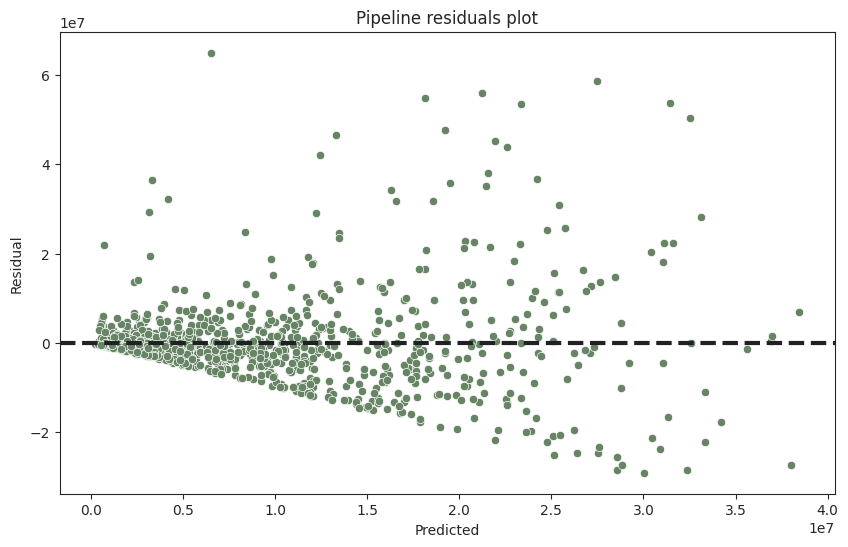

In [24]:
y_pred = results[1][4].predict(X_test)

create_model_report(results[1][0], y_test, y_pred)